In [1]:
# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import matplotlib.dates as dates
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates
import math
import itertools
import pandas.tseries.offsets as offsets

## データの読み込み

In [2]:
# 厚生労働省の公開データ
url = 'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv'

# データ読み込み
df = pd.read_csv(url, parse_dates=[0])

# 結果確認
display(df.head())

display(df.tail())

,Date,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
0,2020-01-16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Date,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
1054,2022-12-05,47702,2795,554,681,1734,388,506,1091,2096,...,420,147,1188,257,287,561,435,286,332,229
1055,2022-12-06,137193,8129,1826,2159,3657,2102,1993,3321,888,...,2032,849,4100,1230,1262,2236,964,1174,873,813
1056,2022-12-07,149383,7764,1676,1637,4179,1575,1553,3094,3600,...,1389,712,5621,1181,1191,1830,1296,983,919,719
1057,2022-12-08,133065,6641,1609,1483,3809,1335,1433,2849,3436,...,1548,638,5165,982,1091,1853,1130,1025,786,709
1058,2022-12-09,127090,5858,997,1520,3495,1402,1347,2768,3133,...,1428,716,4900,1047,1046,2083,1224,1055,750,645


## データの整形

1. 東京のコロナ感染者数の予測を実施するので、東京コロナ感染者に絞り込む。
2. 予測日数を14日間として、データを学習データと検証用データに分割する。


In [3]:
# 東京のデータだけに絞り込み
df_tokyo = df[["Date", "Tokyo"]]

## 祝休日を説明変数として加える


In [4]:
!pip install jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import jpholiday

# 土日判定をするために、weekdayを取得する
df_tokyo["weekday"] = df_tokyo["Date"].dt.weekday

# holidayの判定をするためのカラムを初期化
df_tokyo["holiday"] = False

list_holiday = []

# 祝日の判定
for i in range(df_tokyo.shape[0]):
  date = df_tokyo.iloc[i,0]
  is_holiday = jpholiday.is_holiday(date)
  list_holiday.append(is_holiday)

df_tokyo["holiday"] = list_holiday

df_tokyo["holiday"].mask(df_tokyo["weekday"] == 5, True, inplace=True)
df_tokyo["holiday"].mask(df_tokyo["weekday"] == 6, True, inplace=True)

del df_tokyo["weekday"]

df_tokyo

<ipython-input-5-4d6bd570370f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo["weekday"] = df_tokyo["Date"].dt.weekday
<ipython-input-5-4d6bd570370f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo["holiday"] = False
<ipython-input-5-4d6bd570370f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,Date,Tokyo,holiday
0,2020-01-16,0,False
1,2020-01-17,0,False
2,2020-01-18,0,True
3,2020-01-19,0,True
4,2020-01-20,0,False
...,...,...,...
1054,2022-12-05,5388,False
1055,2022-12-06,15501,False
1056,2022-12-07,14946,False
1057,2022-12-08,14104,False


In [6]:
# 分割日 mdayの設定 (最終日から14日前)
mday = df_tokyo['Date'].iloc[-1] - offsets.Day(14)


# 訓練用indexと検証用indexを作る
train_index = df_tokyo['Date'] <= mday
test_index  = df_tokyo['Date'] > mday


# 入力データの分割
x_train = df_tokyo[train_index]
x_test  = df_tokyo[test_index]

x_train    = x_train.set_index('Date')
ts_holiday = x_train['holiday']
ts         = x_train['Tokyo']


x_test          = x_test.set_index('Date')
ts_holiday_test = x_test['holiday']

In [7]:
ts

Date
2020-01-16        0
2020-01-17        0
2020-01-18        0
2020-01-19        0
2020-01-20        0
              ...  
2022-11-21     4619
2022-11-22    12758
2022-11-23    12850
2022-11-24     5639
2022-11-25    12938
Name: Tokyo, Length: 1045, dtype: int64

## データの可視化

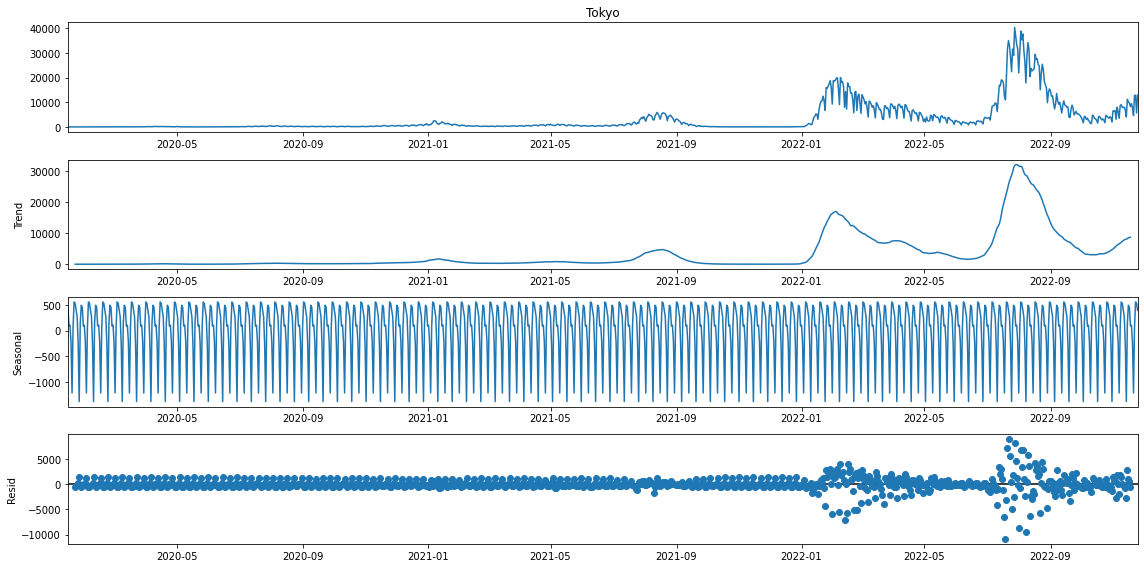

In [8]:
# 周期性の確認
res = sm.tsa.seasonal_decompose(ts, period=14)
fig = res.plot()
fig.set_size_inches(16,8)
fig.tight_layout()

seasonalのデータを見ると周期性があるのが確認できる。
具体的にどのくらいの日数の間隔の周期になっているかを確認するために、データ「ts」の期間を絞り込んで確認してみる。

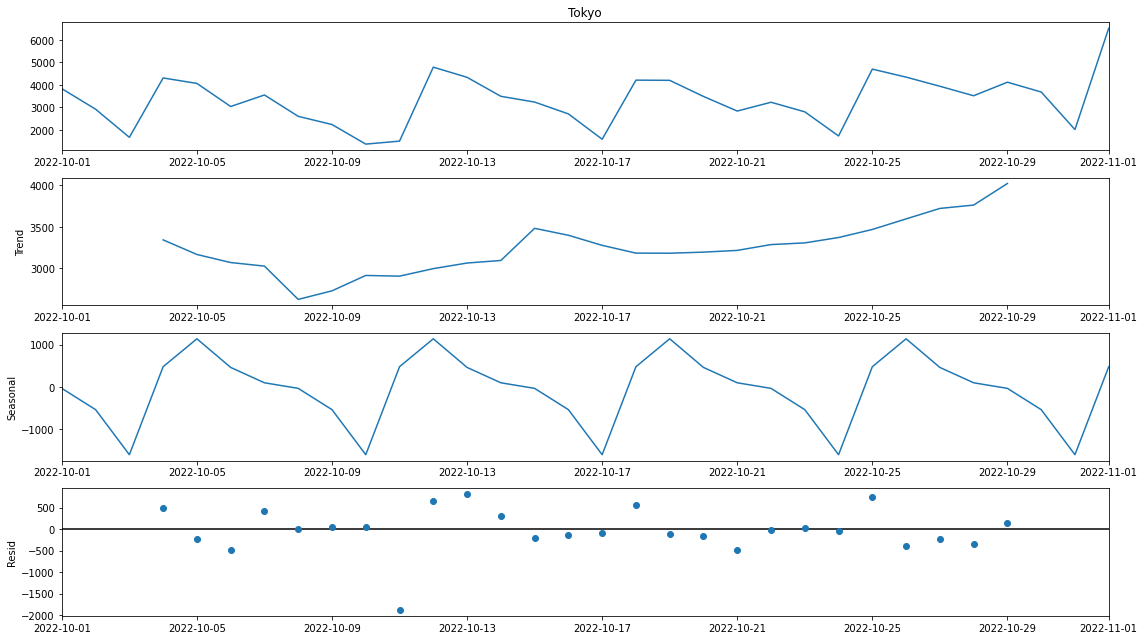

In [9]:
ts_check  = ts.loc['2022/10/1':'2022/11/1']
res_check = sm.tsa.seasonal_decompose(ts_check)

fig    = res_check.plot()
fig.set_size_inches(16,9)
fig.tight_layout()

大体1週間くらいの周期性があることを確認できた。
周期性を確認しやすいようにグラフを描いてみる

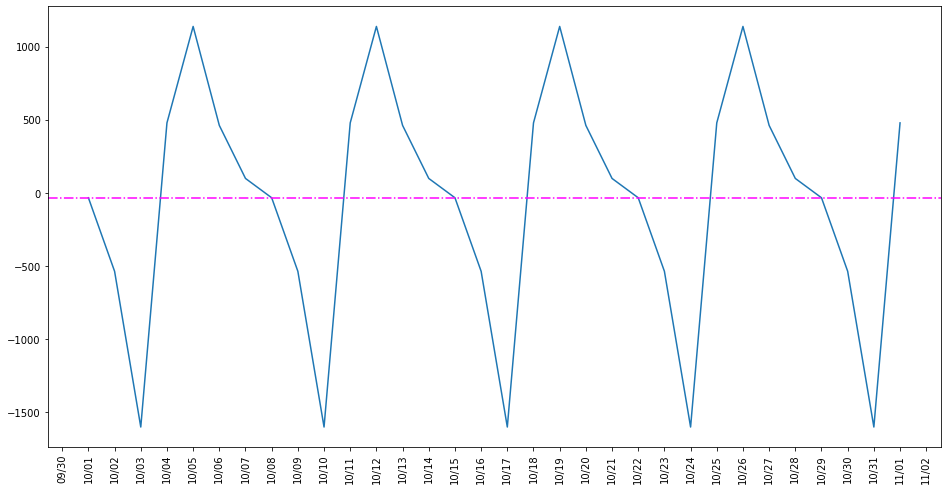

In [10]:
# 初日(22年10月1日)の感染者数を抽出
val = res_check.seasonal[0]

fig, ax = plt.subplots(figsize=(16, 9))

# インデックスを日時にする
res_check.index = pd.to_datetime(ts_check.index)

# データをプロットする
ax.plot(res_check.index, res_check.seasonal)

# グラフのフォーマットなどの調整
formatter = mdates.DateFormatter("%m/%d")
locator   = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
fig.autofmt_xdate(rotation=90, ha="center")

# y=val(10月1日の値）に水平線を引く
plt.axhline(val, ls = "-.", color = "magenta")

plt.show()

7日毎に増減を繰り返している = 7日周期であることを確認できた。

## 自己相関、偏自己相関を描く

周期の確認方法として、自己相関と偏自己相関を描く。

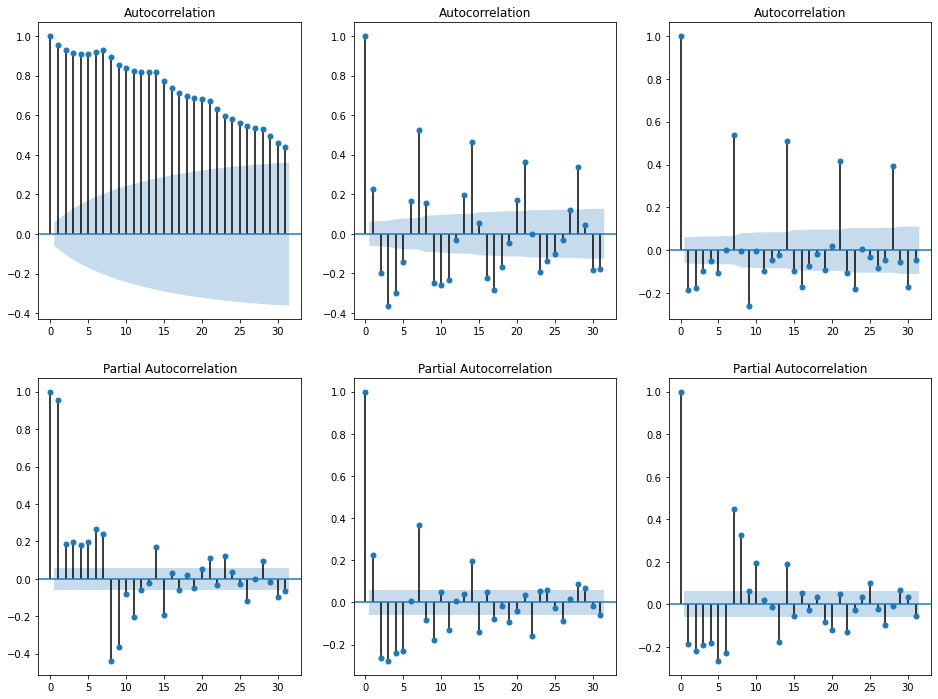

In [11]:
#コレログラム
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

# 原系列の ACF
sm.tsa.graphics.plot_acf(ts, ax=axes[0][0])
# 原系列の PACF
sm.tsa.graphics.plot_pacf(ts, ax=axes[1][0])

# 残差の ACF
sm.tsa.graphics.plot_acf(res.resid.dropna(), ax=axes[0][1])
# 残差の PACF
sm.tsa.graphics.plot_pacf(res.resid.dropna(), ax=axes[1][1])

# 1次の階差系列の ACF
sm.tsa.graphics.plot_acf(ts.diff(1).dropna(), ax=axes[0][2])
# 1次の階差系列の PACF
sm.tsa.graphics.plot_pacf(ts.diff(1).dropna(), ax=axes[1][2])

# グラフを表示する
plt.show()

- 左：原系列
- 真ん中：残差系列（STR分解したときのR成分のコレログラム）
- 右：1次階差系列

これらを見た限り、7日毎のデータで自己相関、偏自己相関が高いことを確認できた。

## ADF検定の実施

原系列と、1次階差系列それぞれでADF検定を実施してみる。

In [12]:
print("-------------原系列--------------")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(ts, regression="nc")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(ts, regression="c")
# トレンド項あり（1次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(ts, regression="ct")
# トレンド項あり（1次+非線形トレンド）、定数項あり
ctt = sm.tsa.stattools.adfuller(ts, regression="ctt")

print("nc  p-value:" + str(nc[1]))
print("c   p-value:" + str(c[1]))
print("ct  p-value:" + str(ct[1]))
print("ctt p-value:" + str(ctt[1]))


print()
print("-------------1次階差系列--------------")
ts_diff = ts.diff().dropna()

# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(ts_diff, regression="nc")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(ts_diff, regression="c")
# トレンド項あり（1次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(ts_diff, regression="ct")
# トレンド項あり（1次+非線形トレンド）、定数項あり
ctt = sm.tsa.stattools.adfuller(ts_diff, regression="ctt")

print("nc  p-value:" + str(nc[1]))
print("c   p-value:" + str(c[1]))
print("ct  p-value:" + str(ct[1]))
print("ctt p-value:" + str(ctt[1]))

-------------原系列--------------
nc  p-value:0.009573119876575878
c   p-value:0.02002909132213399
ct  p-value:0.002512082950178309
ctt p-value:0.00350762320839362

-------------1次階差系列--------------
nc  p-value:2.0354813843292222e-09
c   p-value:3.2008569686399704e-08
ct  p-value:4.7450323783514347e-07
ctt p-value:2.899844523599394e-06


原系列も1次階差系列もともにすべてのp値が5%以下であるので、定常過程と言える。

（本当は、原系列は非定常過程、1次階差系列は定常過程となってほしかったのですが、、、）

### ARIMAモデルの構築

ADF検定で確認したように1次階差系列は定常データとなるため、パラメータ$d$を$1$とする。残りのパラメータを探索する。

#### ARMAモデルを構築する。

1次階差系列に対して$ARMA(p,q)$を構築して最適パラメータを探索する。

In [13]:
# トレンド項なし、定数項なし
params2 = sm.tsa.arma_order_select_ic(ts.diff().dropna(), ic='bic')
params2

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'bic':               0             1             2
 0  18703.759362  18628.210203  18561.929815
 1  18673.107342  18576.473558  18568.628838
 2  18627.697501  18558.172806  18389.451017
 3  18595.449439  18549.534052  18415.993586
 4  18567.002864  18534.032081  18301.924182, 'bic_min_order': (4, 2)}

結果、ARMAモデルのパラメータが$(4,2)$であることを確認できた。

よって、ARIMAモデルのパラメータ$(p,d,q) = (4,1,2)$が最適パラメータと言える。

## SARIMAモデルの構築

ARIMAのパラメータがわかったので、$SRIMA(p,d,q)(P,D,Q)[s]$の残りのパラメータ成分$(P,D,Q)$を探索する。

グリッドサーチでSARIMAの各パラメータを探索する。探索する時の基準にはAICとBICがあるが、今回はBICを使うことにする。（AICは複雑なモデルを評価しがち？とのことなので。）

SRAIMAの季節変動成分[s]は上で確認した周期日数である7をあてはめてモデルを構築する。一般的なやり方もデータの周期間隔を決め打ちで設定するようなので、今回もそれに従った。

In [14]:
# SARIMAのseasonal成分のパラメータを推定するために、各パラメータのパターンを作る
p = range(0, 4)
d = range(0, 4)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

# '7'は周期性が明らかに7だから決め打ちで設定している。
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [15]:
best_param_seasonal = [0,0,0,0]
best_bic = 100000

best_param = (4,1,2)

for param_seasonal in seasonal_pdq:
  try:
    mod = sm.tsa.statespace.SARIMAX(endog = ts,
                                    exog  = ts_holiday,
                                    order = best_param,
                                    seasonal_order = param_seasonal,
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)
    results = mod.fit()
    print('ARIMA{}x{}7 - BIC:{}'.format(best_param, param_seasonal, results.bic))
    
    if best_bic > results.bic:
        best_param_seasonal = param_seasonal
        best_bic = results.bic
  
  except:
    continue
print('*BEST ARIMA{}x{}7 - AIC:{}'.format(best_param, best_param_seasonal, best_bic))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(4, 1, 2)x(0, 0, 0, 7)7 - BIC:18621.362554281743


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(4, 1, 2)x(0, 0, 1, 7)7 - BIC:18163.895328028415


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(0, 0, 2, 7)7 - BIC:17906.597263670872


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(4, 1, 2)x(0, 0, 3, 7)7 - BIC:17812.5677506954


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so in

ARIMA(4, 1, 2)x(1, 0, 0, 7)7 - BIC:17900.878198344566


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(4, 1, 2)x(1, 0, 1, 7)7 - BIC:17906.08932929893


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(1, 0, 2, 7)7 - BIC:17819.942814646376


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(1, 0, 3, 7)7 - BIC:17759.88013093797


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so in

ARIMA(4, 1, 2)x(2, 0, 0, 7)7 - BIC:17866.509952262495


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(2, 0, 1, 7)7 - BIC:17871.069553383364


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(2, 0, 2, 7)7 - BIC:17877.625687289445


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(4, 1, 2)x(2, 0, 3, 7)7 - BIC:17784.165649449613


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so in

ARIMA(4, 1, 2)x(3, 0, 0, 7)7 - BIC:17691.61614225402


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(3, 0, 1, 7)7 - BIC:17760.942185669905


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(3, 0, 2, 7)7 - BIC:17767.676984701604


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(3, 0, 3, 7)7 - BIC:17773.79882296296
*BEST ARIMA(4, 1, 2)x(3, 0, 0, 7)7 - AIC:17691.61614225402


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so in

In [16]:
print("(p,d,q)")
print(best_param)

print()
print("(P,D,Q)")
print(best_param_seasonal)

(p,d,q)
(4, 1, 2)

(P,D,Q)
(3, 0, 0, 7)


## SRAIMAの構築

選んだパラメータを使って、SARIMAモデルを構築する。

In [17]:
sarima_model = sm.tsa.SARIMAX(endog = ts,
                              exog  = ts_holiday,
                              order=best_param,
                              seasonal_order=best_param_seasonal).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: M

## 検証データを使って予測する


In [18]:
min_date = x_test.index.min()
max_date = x_test.index.max()

predict = sarima_model.get_prediction(start = min_date,
                                      end   = max_date,
                                      exog = ts_holiday_test)

predict_value = predict.predicted_mean
display(predict_value)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2022-11-26    11352.755994
2022-11-27     9710.246908
2022-11-28     8372.215509
2022-11-29    14060.304641
2022-11-30    13808.203899
2022-12-01    10347.983342
2022-12-02    12863.162822
2022-12-03    12534.029384
2022-12-04    11419.328843
2022-12-05     9930.920314
2022-12-06    15142.087830
2022-12-07    15050.141631
2022-12-08    11069.113280
2022-12-09    14343.721193
Freq: D, Name: predicted_mean, dtype: float64

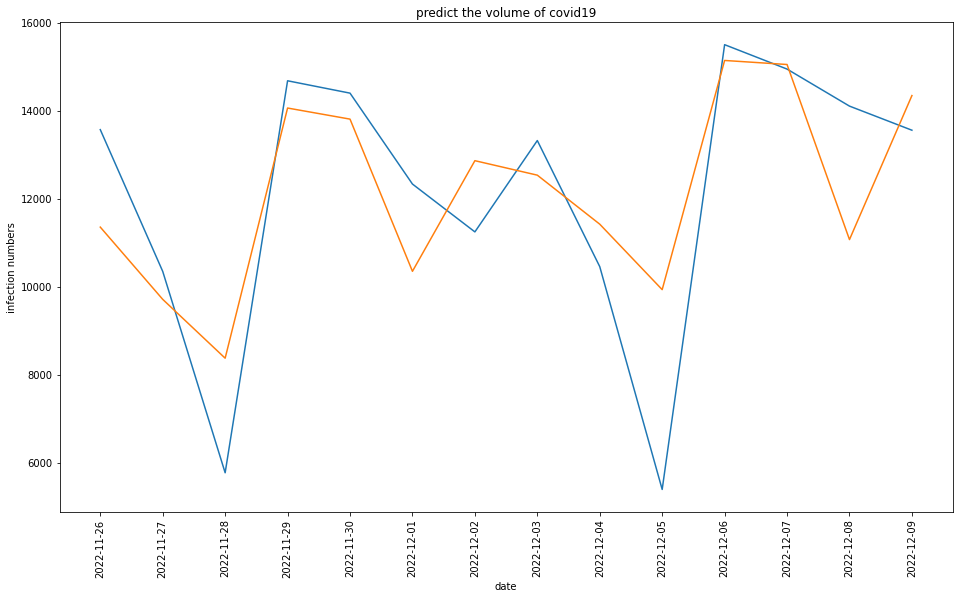

In [19]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(16,9))

# データのプロット
plt.plot(x_test.index, x_test['Tokyo'])  # 実データをプロット
plt.plot(predict_value)  # 予測データをプロット


# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

locator = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(locator)

# titleなど
ax.set_title('predict the volume of covid19')
ax.set_xlabel('date')
ax.set_ylabel('infection numbers')


plt.show()

## MAPEの計算

今回は予測精度の評価指標としてMAPEを使う。（特に理由は無い）

In [20]:
def Mape(predict, observed):
  absolute_diff_percentage =  abs( (predict - observed) / observed)
  sum_abs_diff = sum(absolute_diff_percentage)
  mape = sum_abs_diff / len(predict)

  return mape

In [21]:
mape = Mape(predict_value, x_test["Tokyo"].values)

print("mape : " + str(mape * 100) + " %")

mape : 16.875992667693314 %
